# Frozen Lake

In [1]:
%reset -f
import numpy as np
import torch
from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import gym

import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional

#from gym.envs.toy_text.frozen_lake import generate_random_map

In [2]:
# redifne this map to put starting and ending point in random location
# TODO: Can we do this with decorators?
def generate_random_map(size: int = 8, p: float = 0.8) -> List[str]:
    """Generates a random valid map (one that has a path from start to goal)
    Args:
        size: size of each side of the grid
        p: probability that a tile is frozen
    Returns:
        A random valid map
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res,sx,sy):
        frontier, discovered = [], set()
        frontier.append((sx, sy))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        sx = np.random.randint(size); sy = np.random.randint(size)
        res[sx][sy] = "S"
        gx = np.random.randint(size); gy = np.random.randint(size)
        while res[gx][gy] == "S": # we don't want to overwrite the S
            gx = np.random.randint(size); gy = np.random.randint(size)
        res[gx][gy] = "G"   
        valid = is_valid(res,sx,sy)
    return ["".join(x) for x in res]

In [3]:
gSize = 6 # grid size
nH = 2.    # desired number of hole: this is probabilistic
pH = 1 - nH/(gSize*gSize) # probability of  grid being a hole

desc = generate_random_map(size= gSize, p= pH)

In [4]:
env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False)
env.reset()
#plt.imshow(env.render(mode="rgb_array"))
env.render()
env.close()


FFFHFF
FFFFFF
FFFFFF
FHFFFF
FFSFGF
FFFFFF


In [43]:
class FrozenLakeWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(0,1,shape=(3,gSize,gSize), dtype=np.int32)
        # self.reward_dist_weight = reward_dist_weight
        # self.reward_ctrl_weight = reward_ctrl_weight
    def oneHot(self,s):
        x = np.zeros(gSize*gSize)
        x[s] = 1
        state_ = np.array([ x.reshape(gSize,gSize),
                         np.array(self.env.desc == b"F").astype("int32"),
                         np.array(self.env.desc == b"G").astype("int32")
                          ])
        return state_ 
    
    def reset(self):
        o = self.env.reset()
        return self.oneHot(o)

    def step(self, action):
        o, r, done, info = self.env.step(action)
        return oneHot(o), reward, done, info

In [44]:
env2 = FrozenLakeWrapper(env)

In [45]:
env2.render()


FFFHFF
FFFFFF
FFFFFF
FHFFFF
FFSFGF
FFFFFF


In [54]:
class FrozenLakeWrapped(gym.Env):
    def __init__(self):
        self.size = 6 # grid size
        nH = 2.    # desired number of hole: this is probabilistic
        pH = 1 - nH/(gSize*gSize) # probability of  grid being a hole
        desc = generate_random_map(size= gSize, p= pH)
        self.env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False)
        self.observation_space = gym.spaces.Box(0,1,shape=(3,gSize,gSize), dtype=np.int32)
        self.action_space = self.env.action_space
    def oneHot(self,s):
        x = np.zeros(self.size*self.size)
        x[s] = 1
        state_ = np.array([ x.reshape(self.size,self.size),
                         np.array(self.env.desc == b"F").astype("int32"),
                         np.array(self.env.desc == b"G").astype("int32")
                          ])
        return state_ 
    
    def reset(self):
        o = self.env.reset()
        return self.oneHot(o)

    def step(self, action):
        o, r, done, info = self.env.step(action)
        return oneHot(o), reward, done, info
    
    def render(self):
        self.env.render()

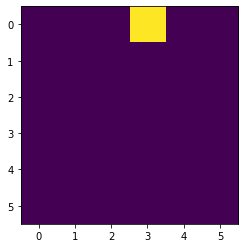

In [62]:
env3 = FrozenLakeWrapped()
plt.imshow(env3.reset()[0])